# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [117]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [118]:
Npts = 100
len = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,len,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [119]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [120]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [121]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [123]:
@time ops = NavierStokes.set_operators_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

  4.285867 seconds (425.57 k allocations: 1.112 GiB, 4.82% gc time)


(Zero-padded convolution for a 202 × 102 matrix, Zero-padded convolution for a 202 × 102 matrix, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.Schur{Float64,200}(Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; -0.102877 1.0 … 0.0 0.0; … ; 0.0193821 0.00638923 … 1.0 0.0; 0.0166382 0.0007666 … 0.442732 1.0]
[-0.11139 0.0114595 … -0.00215896 -0.00185333; 0.0 -0.1095 … -0.000699623 -8.3943e-5; … ; 0.0 0.0 … -0.0816447 -0.0361467; 0.0 0.0 … 0.0 -0.0656785], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), Whirl2d.NavierStokes.Schur{Float64,200}(Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; -0.142241 1.0 … 0.0 0.0; … ; 0.0170773 0.00641681 … 1.0 0.0; 0.0165888 0.00156047 … 0.40574 1.0]
[-0.1271 0.0180788 … -0.00217052 -0.00210843; 0.0 -0.122531 … -0.000786257 -0.000191205; … ; 0.0 0.0 … -0.0979683 -0.0397497; 0.0 0.0 … 0.0 -0.082376], [0.

### Create an initial solution structure

In [127]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [128]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

  6.630557 seconds (349.60 k allocations: 2.292 GiB, 7.22% gc time)


Solution: t = 1.0000000000000007


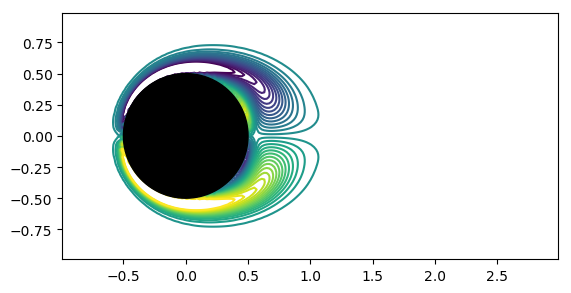

(-0.99, 2.99, -0.99, 0.99)

In [129]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

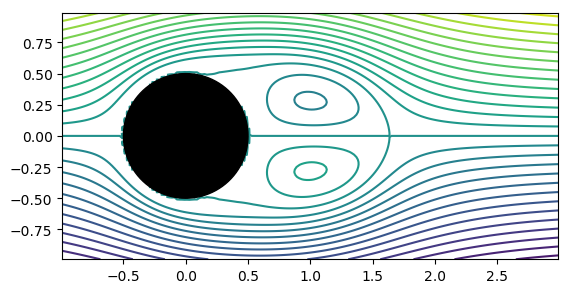

(-0.99, 2.99, -0.99, 0.99)

In [97]:
s.ψ = -L⁻¹(s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-1,1,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")